# Google Colab
Set the Runtime to GPU from the menu on the top left of this webpage

Importing data to Google Colab

In [149]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [150]:
# Copy data to google colab from google drive and unzip
# This may take 1-2 minutes
!cp gdrive/My\ Drive/optical_data.zip .
!unzip optical_data.zip

Archive:  optical_data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [151]:
# You should be able to see 7 Classes here
!ls data

Class1	Class2	Class3	Class4	Class5	Class6	Class7


Sample Output : Class1 Class2	Class3	Class4	Class5	Class6	Class7

# Main Notebook

In [0]:
import os
import sys
import time
import warnings
import random
from random import shuffle

import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from tensorflow.python.lib.io import file_io
from skimage.transform import resize
import numpy as np
import keras
from keras import backend as K
import cv2
import math

warnings.filterwarnings("ignore")


# Data Loading

In [0]:
# Not all data in the dataset has defects. We only use the images which have defects
# This function takes the dataset_type as a parameter. You can pass "Train" or "Test"
# as argument to get the appropriate dataset
def load_data(dataset_type="Train"):
    file_list = {}
    defect_map = {}
    file_name = []
    file_mask = []
    count = 0
    num_classes = 6

    data_dir = "data"
    for x in range(1, num_classes + 1):
        path = os.path.join(os.path.join(data_dir, "Class" + str(x)), dataset_type)
        df = pd.read_fwf(path + "/Label/Labels.txt")
        count = 0
        for i in range(0, len(df)):
            curr_file = path + "/" + str(df.iloc[i][2])
            if (df.iloc[i][1] == 1):
                file_list[curr_file] = path + "/Label/" + str(df.iloc[i][4])
                defect_map[curr_file] = 1
            else:
                fnametest = str(df.iloc[i][2]).split(".")
                file_list[curr_file] = str(path + "/Label/" + fnametest[0] + "_label.PNG")
                defect_map[curr_file] = 0

    items = list(file_list.keys())
    shuffle(items)
    for key in items:
        if ((not os.path.exists(key)) or (not os.path.exists(file_list[key]))):
            # print ("Missing mask for ", key)
            continue

        if defect_map[key] == 1:
            file_name.append(key)
            file_mask.append(file_list[key])
        elif count < 80 * num_classes:
            file_name.append(key)
            file_mask.append(file_list[key])
            count = count + 1

    return file_name, file_mask

Since the dataset is so large that it cannot fit into memory, we will need to use generator functions to iteratively load the dataset

In [0]:
# This is generator class to process data in batches and send them for training
class Surface_Generator(keras.utils.Sequence):

    def __init__(self, image_filenames, labels, batch_size, test=False):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    # return the total number of batches you have i.e., total_files/batch_size
    def __len__(self):
        return math.ceil(len(self.image_filenames)/(self.batch_size))

    # this function is called for every mini-batch to get the images/masks for that mini-batch
    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_arr = []
        mask_arr = []
        # Open a batch of images and their corresponding masks using cv2.imread
        # resize them to 512x512x1 and return an np.array of images and masks
        for image, label in zip(batch_x, batch_y):
            image_arr.append(resize(cv2.imread(image),(512, 512, 1)))
            mask_arr.append(resize(cv2.imread(label),(512, 512, 1)))

        return np.array(image_arr).astype(np.float32), np.array(mask_arr).astype(np.float32)
    
    # for testing we need to get the list of all true masks
    # this function should return all the labels in the dataset set 
    # we will call this function only for the "Test" dataset
    def get_all_masks(self):
        mask_arr = [resize(cv2.imread(mask), (512, 512, 1)) for mask in self.labels]
        return np.array(mask_arr).astype(np.float32)


In [0]:
# Since we already have a split for training and test set,
# we just need to split training set to get a validation set

# Load training data
X, Y = load_data("Train")

In [156]:
# Split the original training data to get training and validation set
# to get X_train, X_val, y_train, y_val
random.seed(0)
dataset = list(zip(X, Y))
shuffle(dataset)
X_train, y_train = zip(*dataset[: int(0.8*len(dataset))])
X_val, y_val = zip(*dataset[int(0.8*len(dataset)):])

# Convert to numpy arrays
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(740,) (740,) (186,) (186,)


The output shape after the split should be 
(740,) (740,) (186,) (186,)

In [157]:
# Free memory
import gc
del X
del Y
gc.collect()

137

# Metrics

Keras.backend to calculate dice coefficient metric and dice coefficient loss function.

Recall that dice_coeff = 2 \* intersection / union

We add a smoothing parameter and modify the formula to

dice_coeff = 2 \* (intersection + smooth) / (union + smooth)

Our objective is to make dice_coeff as close to 1.0 as possible. 
Define and use the appropriate loss function.

In [0]:
# Dice Coefficient metric
def dice_coef(y_true, y_pred):
    smooth = 1
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    return (2. * (intersection + smooth)) / (K.sum(y_true) + K.sum(y_pred) + smooth)


# Dice Coefficient loss
def dice_coef_loss(y_true, y_pred):
    return (1-dice_coef(y_true, y_pred))

# Model

U-net architeture has proved to be very powerful for segmentation tasks.

We will be creating a Unet model based on the paper : 

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)

---

A picture of the architecture we plan to use is provided in the project description pdf.

We will create a Convolutional block module to help us build the model.

Each convolutional block module will contain two trainable layers. 

Each layer will be a Convolution operation followed by batch normalization with relu activation.



The U-net architecture has a contracting path, a convolution and then an expansive path.

We will use instances of the convolutional block to create the contracting and expansive path.

In [0]:
from keras.layers import Conv2DTranspose, Dropout, Activation, BatchNormalization, UpSampling2D, Concatenate
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate
from keras.models import Model

# Create a 2D convolution block. We will use multiple instances of this block to build our U-net model
# This block will contain two layers. 
# Each layer will be a Convolution operation followed by batch normalization with relu activation 
def conv2d_block(input_tensor, n_filters, kernel_size):
    # first layer
    # Create a Conv2D layer with n_filters and a kernel of dimension : kernel_size x kernel_size. 
    # Use same padding and he_normal initializer
    x = Conv2D(n_filters, (kernel_size, kernel_size), padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
    
    # add a BatchNormalization layer
    x = BatchNormalization()(x)
        
    # Add a relu non-linearity (keras.layers.Activation)
    x = Activation('relu')(x)
    
    
    # second layer
    # repeat the above steps (Conv + batchnorm + relu) taking the output of relu layer as input for this convolutional layer
    x = Conv2D(n_filters, kernel_size, padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # return the output tensor
    return x


def get_unet_model(n_filters=16, dropout_prob=0.5, kernel_size=3):
    input_img = Input((512, 512, 1))
    
    # contracting path
    # create a convolutional block with input_img as the input tensor and n_filters
    c1 = conv2d_block(input_img, n_filters, kernel_size)

    # apply a 2d maxpooling with a pool size of 2x2
    p1 = MaxPooling2D(pool_size = (2, 2))(c1)
    
    # add a dropout. Since this the input, set the dropout rate to 0.5 * dropout_prob
    p1 = Dropout(0.5 * dropout_prob)(p1)


    # create another convolutional block. this time use p1 as input tensor and twice the n_filters
    # repeat the same maxpool and dropout but set dropout rate to dropout_prob this time
    c2 = conv2d_block(p1, 2 * n_filters, kernel_size)    
    p2 = MaxPooling2D(pool_size = (2, 2))(c2)
    p2 = Dropout(dropout_prob)(p2)

    # create another block with maxpool and dropout with 4 x n_filters
    c3 = conv2d_block(p2, 4 * n_filters, kernel_size)    
    p3 = MaxPooling2D(pool_size = (2, 2))(c3)
    p3 = Dropout(dropout_prob)(p3)

    # create another block with maxpool and dropout with 8 x n_filters
    c4 = conv2d_block(p3, 8 * n_filters, kernel_size)    
    p4 = MaxPooling2D(pool_size = (2, 2))(c4)
    p4 = Dropout(dropout_prob)(p4)


    # This is the layer where we combine the contractive and expansive paths
    # create a convolutional block with 16 x n_filters. No pooling/dropout this time
    c5 = conv2d_block(p4, 16 * n_filters, kernel_size)

    
    # Expansive path

    # We will create a similar structure as the contracting path but instead of 
    # convolutional operation, we will use Deconvolution operations

    # Create a Conv2DTranspose layer (deconvolution) with 8 x n_filters, kernel_size, 
    # 2x2 strides and same padding
    u6 = Conv2DTranspose(8 * n_filters, (kernel_size, kernel_size), padding = 'same', strides = (2, 2))(c5)
    
    # Concatenate u6 and c4 using keras.layers.concatenate
    u6 = concatenate([u6, c4])
    
    # dropout
    u6 = Dropout(dropout_prob)(u6)
    
    # create a convolutional block with 8 x n_filters
    c6 = conv2d_block(u6, 8 * n_filters, kernel_size)
    

    # Create a similar module as previous, deconv, concatenate, dropout, conv2d_block
    # Please ensure that the number of filters you use match the n_filters of 
    # the layer you are concatenating with
    u7 = Conv2DTranspose(4 * n_filters, (kernel_size, kernel_size), padding = 'same', strides = (2, 2))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout_prob)(u7)
    c7 = conv2d_block(u7, 4 * n_filters, kernel_size)
    
    # Create a similar module as previous, deconv, concatenate, dropout, conv2d_block
    u8 = Conv2DTranspose(2 * n_filters, (kernel_size, kernel_size), padding = 'same', strides = (2, 2))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout_prob)(u8)
    c8 = conv2d_block(u8, 2 * n_filters, kernel_size)


    # Create a similar module as previous, deconv, concatenate, dropout, conv2d_block
    u9 = Conv2DTranspose(n_filters, (kernel_size, kernel_size), padding = 'same', strides = (2, 2))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout_prob)(u9)
    c9 = conv2d_block(u9, n_filters, kernel_size)

    # apply a 1x1 convolution on c9 to get an output with a single channel
    # This is the final model output. We want the pixel values in the mask to be
    # either 0 or 1. Choose an activation function which can give values in that
    # range.
    outputs = Conv2D(1, 1, activation = 'sigmoid')(c9)

    model = Model(inputs=[input_img], outputs=[outputs])

    return model

In [0]:
model_name = "unet"
model = get_unet_model()

In [0]:
batch_size = 8
num_epochs = 50
# Compile the model
model.compile(loss=dice_coef_loss, optimizer=Adam(lr=0.0055), metrics=[dice_coef])

In [0]:
# Create generator objects for training and validation
num_training_samples = len(X_train)
num_validation_samples = len(X_val)
training_batch_generator = Surface_Generator(X_train, y_train, batch_size)
validation_batch_generator = Surface_Generator(X_val, y_val, batch_size)

In [0]:
# callbacks for saving models and early stopping
checkpointer = ModelCheckpoint(model_name + "/weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor=dice_coef, verbose=1,
                               save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [165]:
# Fit model
# This will take ~1.5-2 minutes per epoch on a GPU
stmillis = int(round(time.time() * 1000))
history = model.fit_generator(generator=training_batch_generator,
                    steps_per_epoch=(num_training_samples // batch_size),
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=validation_batch_generator,
                    validation_steps=(num_validation_samples // batch_size),
                    use_multiprocessing=True,
                    workers=5,
                    max_queue_size=1,
                    callbacks=[checkpointer, early_stopping])
endmillis = int(round(time.time() * 1000))
print("Time taken: ", endmillis - stmillis)

Epoch 1/50
92/92 [==============================] - 111s 1s/step - loss: 0.9059 - dice_coef: 0.0941 - val_loss: 0.9556 - val_dice_coef: 0.0444
Epoch 2/50
92/92 [==============================] - 104s 1s/step - loss: 0.6477 - dice_coef: 0.3523 - val_loss: 0.9606 - val_dice_coef: 0.0394
Epoch 3/50
92/92 [==============================] - 104s 1s/step - loss: 0.6176 - dice_coef: 0.3824 - val_loss: 0.9448 - val_dice_coef: 0.0552
Epoch 4/50
92/92 [==============================] - 104s 1s/step - loss: 0.6196 - dice_coef: 0.3804 - val_loss: 0.9408 - val_dice_coef: 0.0592
Epoch 5/50
92/92 [==============================] - 103s 1s/step - loss: 0.6015 - dice_coef: 0.3985 - val_loss: 0.9474 - val_dice_coef: 0.0526
Epoch 6/50
92/92 [==============================] - 105s 1s/step - loss: 0.5795 - dice_coef: 0.4205 - val_loss: 0.9450 - val_dice_coef: 0.0550
Epoch 7/50
92/92 [==============================] - 104s 1s/step - loss: 0.5711 - dice_coef: 0.4289 - val_loss: 0.9303 - val_dice_coef: 0.0697

In [0]:
# Save the trained weights
model.save("unet" + ".h5")

# Save model config as json
model_json = model.to_json()
with open("unet" + ".json", "w") as json_file:
    json_file.write(model_json)

# Persist the model to your google drive
!cp unet.* gdrive/My\ Drive/

In [206]:
# Confirm if model did get saved
!ls -ltr gdrive/My\ Drive/unet*

-rw------- 1 root root    33848 Apr 15 02:21 'gdrive/My Drive/unet.json'
-rw------- 1 root root 26261816 Apr 15 02:21 'gdrive/My Drive/unet.h5'


In [0]:
# In case you wish to load your saved model
!cp gdrive/My\ Drive/unet* .

model.load_weights("unet.h5")

In [227]:
import gc
gc.collect()

# Load test data in X_test and y_test
X_test, y_test = load_data("Test")
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
print (X_test.shape, y_test.shape)

(454,) (454,)


Output shape should be (454,) (454,)

[OPTIONAL] Shuffle and select 25 elements for quick testing


In [0]:
np.random.seed = 629
p = np.random.permutation(len(X_test))
X_test = X_test[p]
y_test = y_test[p]

X_test = X_test[:25]
y_test = y_test[:25]

In [0]:
# Predict using model.predict_generator().
test_data_generator =  Surface_Generator(X_test, y_test, 1)
y_pred = model.predict_generator(test_data_generator, steps = len(X_test))

In [230]:
# y_true will have the true masks
y_true = test_data_generator.get_all_masks()
print ("Dice coefficient on test data: ", K.get_value(dice_coef(y_true, y_pred)))

Dice coefficient on test data:  0.5991386


The dice coefficient on test data should be close to 0.7



Visulaizing the mask for a random image

In [0]:
# Convert sigmoid outputs to binary class labels
y_pred[20][y_pred[20] >= 0.5] = 1
y_pred[20][y_pred[20] < 0.5] = 0

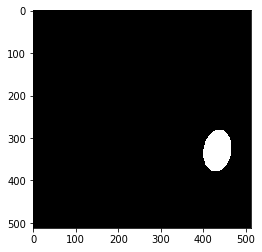

In [0]:
import matplotlib.pyplot as plt
plt.imshow(y_true[20][:,:,0], cmap='gray')
plt.show()

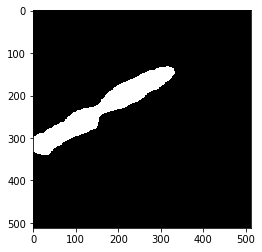

In [0]:
plt.imshow(y_pred[20][:,:,0], cmap='gray')
plt.show()

In [0]:
# Dice coefficient on this example
K.get_value(dice_coef(y_true[20], y_pred[20]))

4.5244775e-05